## Crossign Accuracy in the EPL

### Imports and Fonts

In [130]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patheffects as path_effects
import matplotlib.font_manager as fm
from matplotlib.patches import Ellipse
import matplotlib.patches as mpatches
from matplotlib import cm
from highlight_text import fig_text, ax_text
from ast import literal_eval

from PIL import Image
import urllib
import os
import requests
import json

# -- For Logos and images
from matplotlib.transforms import Bbox
class BboxLocator:
    def __init__(self, bbox, transform):
        self._bbox = bbox
        self._transform = transform
    def __call__(self, ax, renderer):
        _bbox = self._transform.transform_bbox(self._bbox)
        return ax.figure.transFigure.inverted().transform_bbox(_bbox)

In [131]:
from matplotlib.font_manager import FontProperties

# Specify your font
regular = FontProperties(fname="C:\\Users\\George\\Documents\\Football Analytics\\Kanit-Regular.ttf")  # Update the path to where the font is installed on your system
light = FontProperties(fname="C:\\Users\\George\\Documents\\Football Analytics\\Kanit-Light.ttf")  # Update the path to where the font is installed on your system
bold = FontProperties(fname="C:\\Users\\George\\Documents\\Football Analytics\\Kanit-Bold.ttf")  # Update the path to where the font is installed on your system

### Read the data

Here we get detailed statistics for all players in the current season.

In [132]:
league = 'Premier League'
mins = 1710
quant = 90

In [133]:
data = pd.read_csv(f'C:\\Users\\George\\Documents\\Football Analytics\\fotmob_{league}_data.csv')

Next, we group the data to summarize our findings.

In [134]:
data['value'].fillna(0, inplace=True)

In [135]:
numeric_column = pd.to_numeric(data['value'], errors='coerce')
# Find the indices of rows with NaN values in the numeric_column
nan_indices = numeric_column[numeric_column.isnull()].index
# Filter the original DataFrame to see the non-numeric values
non_numeric_values = data.loc[nan_indices]
data = data.drop(nan_indices)
data.reset_index(drop=True, inplace=True)
data['value'] = data['value'].astype(float)


In [136]:
data_minutes = (
    data[['player_id', 'minutes_played', 'match_id']].drop_duplicates()
    .groupby(['player_id'])['minutes_played'].sum()
    .reset_index()
)

data_groupped = (
    data.groupby(['team_name', 'team_id', 'player_id', 'full_name', 'variable'])
    ['value'].sum()
    .reset_index()
)

data_groupped = (
    pd.merge(data_groupped, data_minutes, how='left', on='player_id')
)

Finally, we filter only variables of interest.

In [137]:
vars_to_keep = ['Accurate crosses', 'Attempted crosses', 'Assists', 'xA']

data_groupped = (
    data_groupped[
        (data_groupped.minutes_played > mins) &
        (data_groupped.variable.isin(vars_to_keep))
    ].reset_index(drop=True)
)

In [138]:
data_groupped = (
    data_groupped.pivot(index=['team_name', 'team_id', 'player_id', 'full_name', 'minutes_played'], 
    columns=['variable'], values=['value'])
    .droplevel(0, axis=1).reset_index()
)

data_groupped.head()

variable,team_name,team_id,player_id,full_name,minutes_played,Accurate crosses,Assists,Attempted crosses
0,AFC Bournemouth,8678,160447,Adam Smith,2156,18.0,2.0,39.0
1,AFC Bournemouth,8678,439369,Ryan Christie,2918,19.0,5.0,73.0
2,AFC Bournemouth,8678,562724,Lewis Cook,2792,34.0,3.0,132.0
3,AFC Bournemouth,8678,591734,Dominic Solanke,3331,3.0,3.0,6.0
4,AFC Bournemouth,8678,785411,Marcos Senesi,2247,11.0,5.0,25.0


In [139]:
data_groupped.rename(columns={'Attempted crosses': 'Crosses attempted'}, inplace=True)

In [140]:
top_crossers = data_groupped['Crosses attempted'].quantile(quant/100)
data_groupped = data_groupped[data_groupped['Crosses attempted'] > top_crossers].reset_index(drop=True)

We clean things up for the table and add player positions.

In [141]:
data_clean = data_groupped.copy()
columns_to_skip = ['team_name', 'team_id', 'player_id', 'full_name', 'minutes_played', 'cross_success']
data_clean = data_clean.assign(cross_success = lambda x: x['Accurate crosses']/x['Crosses attempted'])
for column in data_clean.columns:
    if column in columns_to_skip:
        continue
    else:
        data_clean[column] = (data_clean[column]/data_clean['minutes_played'])*90


In [142]:
def get_player_position(player_id):
    '''
    This function gets the main player position based on it's Fotmob ID.
    '''

    url = f'https://www.fotmob.com/api/playerData?id={player_id}'
    response = requests.get(url)
    content = json.loads(response.content)
    player_positions = content.get('positionDescription').get('positions')
    for position in player_positions:
        if position['isMainPosition']:
            return position['strPosShort']['label']
        else:
            continue

In [143]:
data_clean['position'] = [get_player_position(x) for x in data_clean['player_id']]
data_clean['position'].unique()

array(['DM', 'LW', 'RW', 'LB', 'LM', 'AM', 'RB', 'LWB'], dtype=object)

In [144]:
data_clean = data_clean.sort_values(by='Crosses attempted', ascending=True).reset_index(drop=True)

## The Table

In [145]:
def draw_player_image_at_ax(player_id, ax, grayscale=False):
    '''
    '''
    fotmob_url = 'https://images.fotmob.com/image_resources/playerimages/'
    club_icon = Image.open(urllib.request.urlopen(f'{fotmob_url}{player_id:.0f}.png'))
    if grayscale:
        club_icon = club_icon.convert('LA')
    ax.imshow(club_icon)
    ax.axis('off')
    return ax

def draw_club_image_at_ax(team_id, ax, grayscale=False):
    '''
    '''
    fotmob_url = 'https://images.fotmob.com/image_resources/logo/teamlogo/'
    club_icon = Image.open(urllib.request.urlopen(f'{fotmob_url}{team_id:.0f}.png'))
    if grayscale:
        club_icon = club_icon.convert('LA')
    ax.imshow(club_icon)
    ax.axis('off')
    return ax

In [146]:
todays_date = pd.to_datetime('today').strftime('%d %B %Y')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17


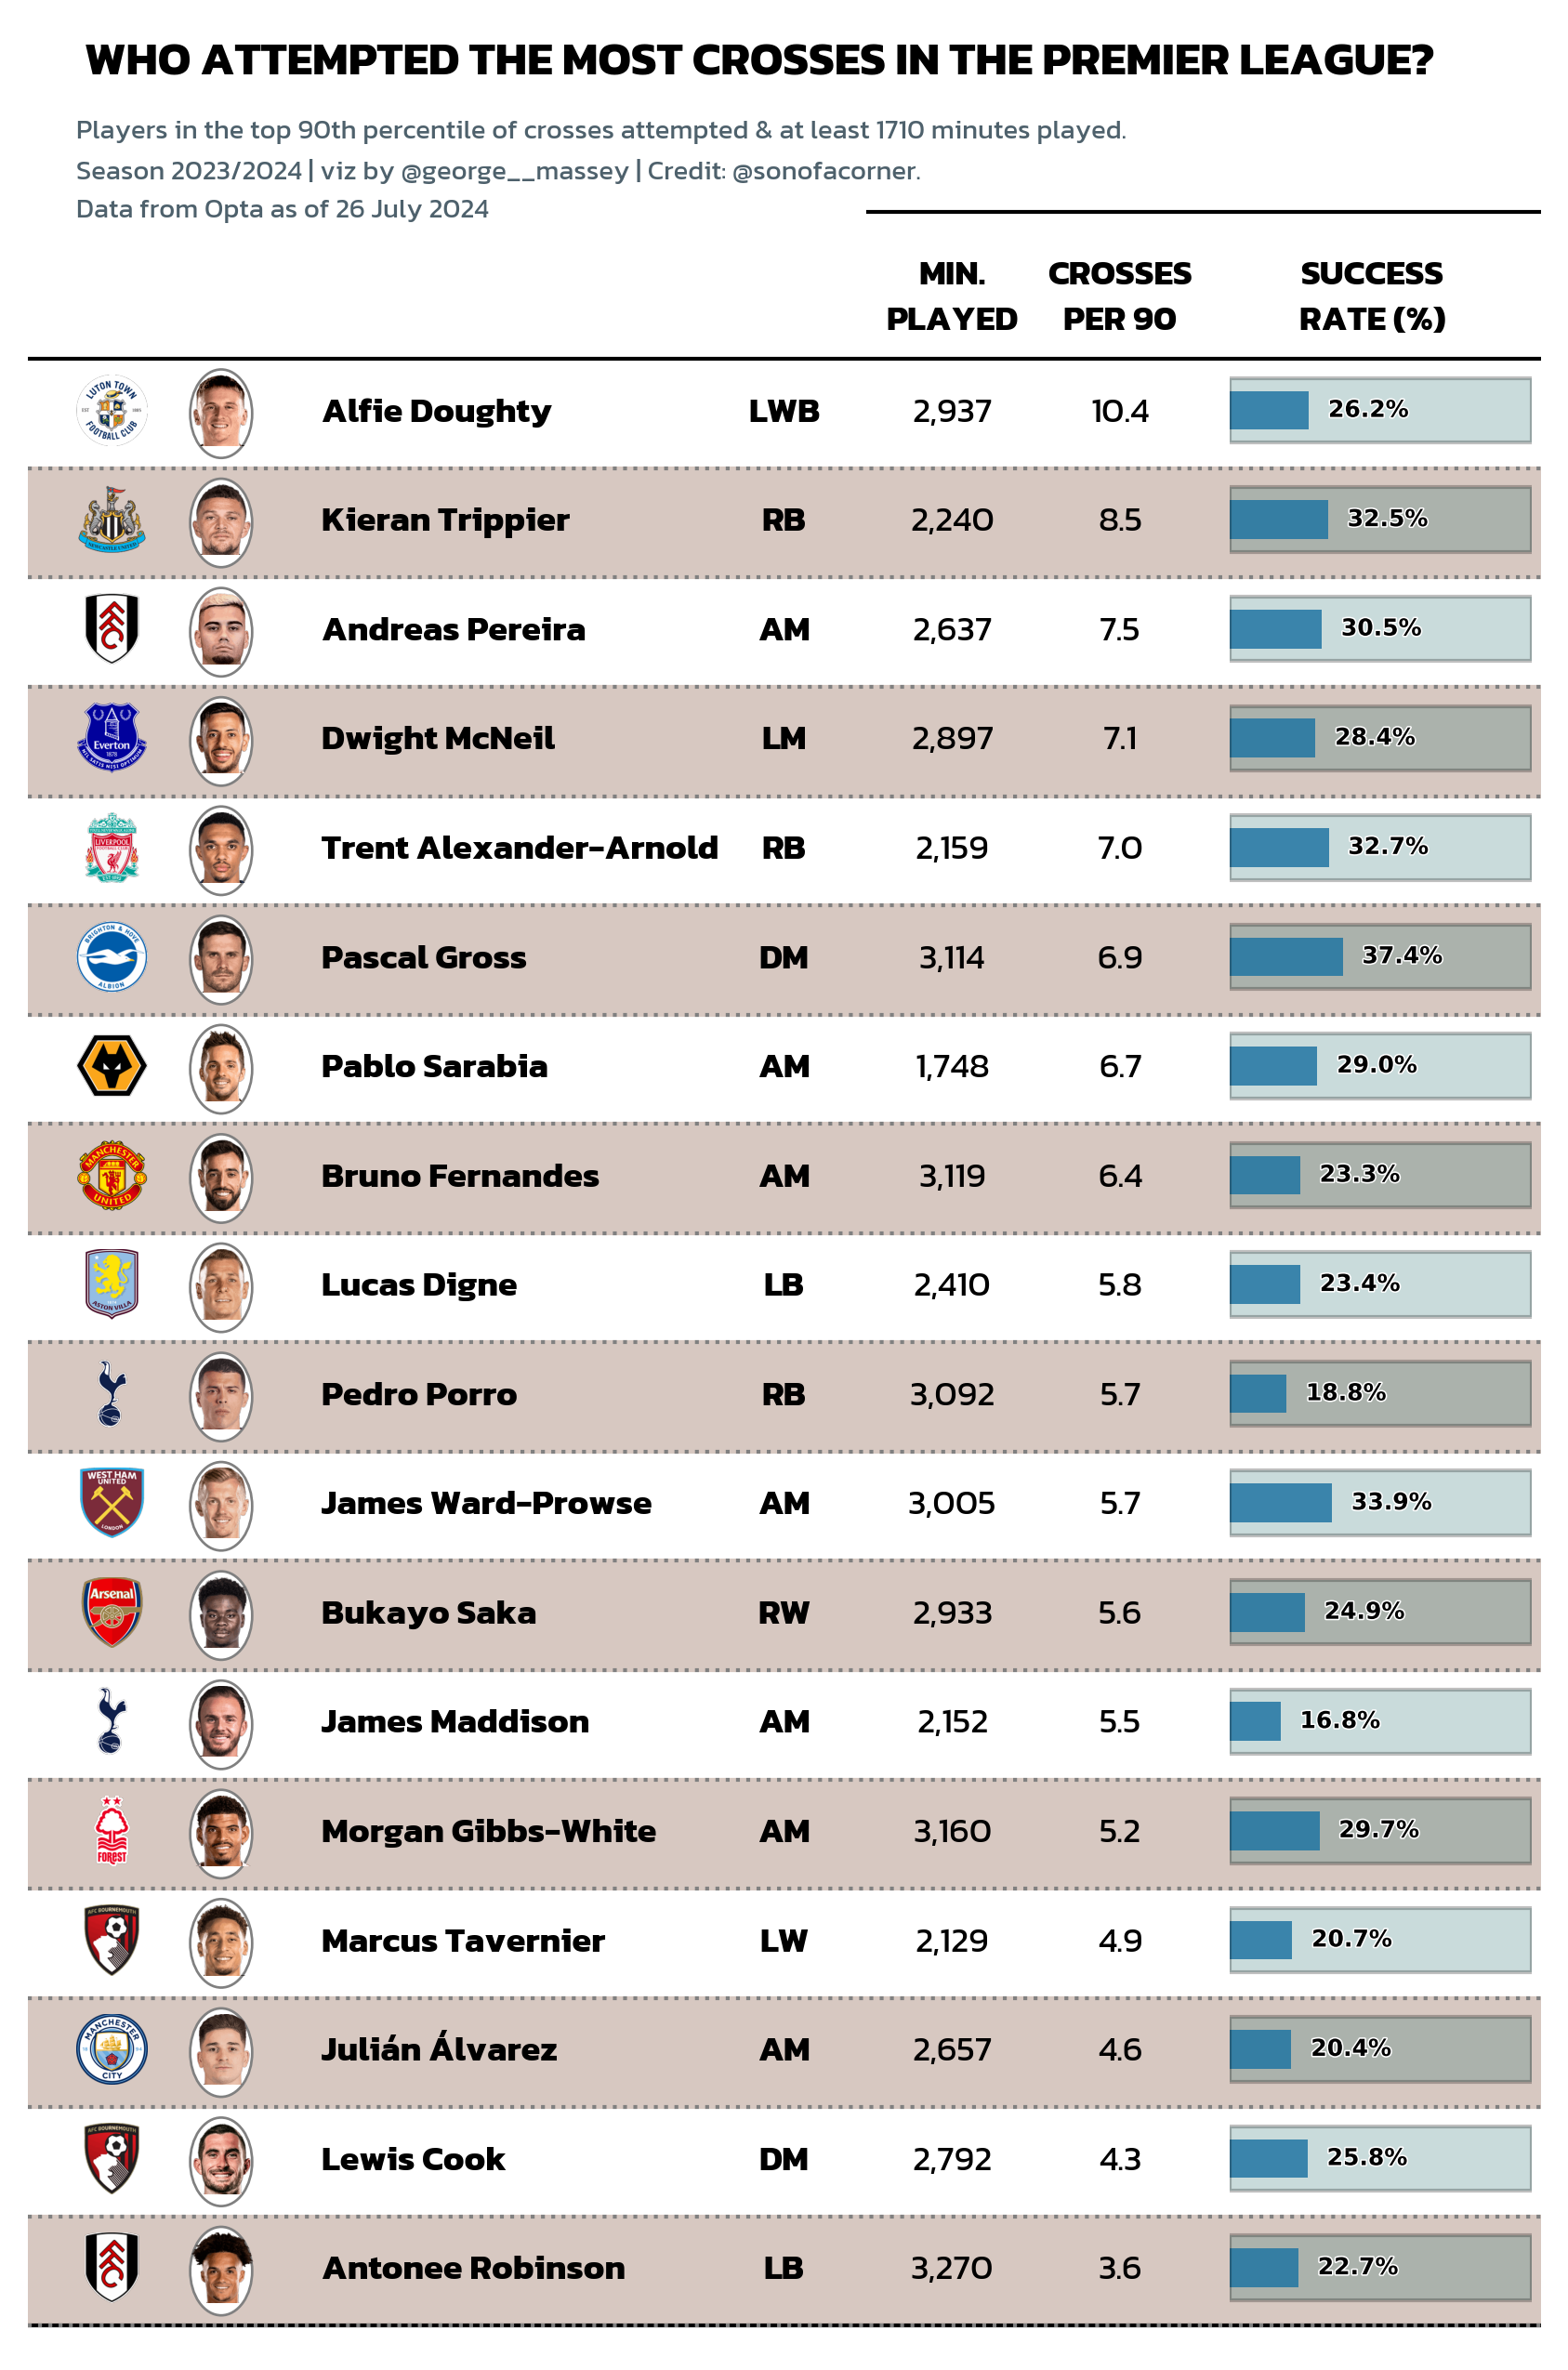

In [147]:
fig = plt.figure(figsize=(7,10), dpi=300)
ax = plt.subplot()

nrows = data_clean.shape[0]
ncols = data_clean.shape[1] - 3 # because I want to remove aprox. 3 columns from my DF

ax.set_xlim(0, ncols + 1)
ax.set_ylim(-.65, nrows + 1)

# calculate asymmetry of x and y axes: (I have no idea how this works)
x0, y0 = ax.transAxes.transform((0, 0)) # lower left in pixels
x1, y1 = ax.transAxes.transform((1, 1)) # upper right in pixes
dx = x1 - x0
dy = y1 - y0
maxd = max(dx, dy)
width = .26 * maxd / dx
height = .81 * maxd / dy

# Iterate
for y in range(0, nrows):
    print(y)
    # -- Club Logo
    bbox = Bbox.from_bounds(0, y - .295, 1, .65)
    logo_ax = fig.add_axes([0, 0, 0, 0], axes_locator=BboxLocator(bbox, ax.transData))
    draw_club_image_at_ax(data_clean['team_id'].iloc[y], logo_ax)
    # -- Player picture
    circle = Ellipse((1.15, y), width, height, ec='grey', fc=fig.get_facecolor(), transform=ax.transData, lw=.65)
    bbox = Bbox.from_bounds(.65, y - .295, 1, .65)
    logo_ax = fig.add_axes([0, 0, 0, 0], axes_locator=BboxLocator(bbox, ax.transData))
    draw_player_image_at_ax(data_clean['player_id'].iloc[y], logo_ax)
    ax.add_artist(circle)
    # -- Player name
    ax_text(
        x=1.75, y=y,
        s=data_clean['full_name'].iloc[y],
        weight='bold', size=9,
        ha='left', va='center', ax=ax, fontproperties = bold
    )
    # -- Player position
    ax_text(
        x=4.5, y=y,
        s=data_clean['position'].iloc[y],
        weight='bold', size=9,
        ha='center', va='center', ax=ax, fontproperties = bold
    )
    # -- Minutes played
    ax_text(
        x=5.5, y=y,
        s=f"{data_clean['minutes_played'].iloc[y]:,.0f}",
        size=9,
        ha='center', va='center', ax=ax, fontproperties = regular
    )
    # # -- Crosses
    ax_text(
        x=6.5, y=y,
        s=f"{data_clean['Crosses attempted'].iloc[y]:,.1f}",
        size=9,
        ha='center', va='center', ax=ax, fontproperties = regular
    )
    # # -- Battery Chart
    bbox = Bbox.from_bounds(7.15, y - .295, 1.8, .65)
    battery_ax = fig.add_axes([0, 0, 0, 0], axes_locator=BboxLocator(bbox, ax.transData))
    battery_ax.set_xlim(0,1)
    battery_ax.barh(y=.5, width=data_clean['cross_success'].iloc[y], height=.3, alpha=.85)
    battery_ax.barh(y=.5, width=1, height=.5, alpha=.25, color='#287271', ec='black')
    text_ = battery_ax.annotate(
        xy=(data_clean['cross_success'].iloc[y], .5),
        xytext=(5,0),
        textcoords='offset points',
        text=f"{data_clean['cross_success'].iloc[y]:.1%}",
        ha='left', va='center',
        size=6, weight='bold'
    )
    text_.set_path_effects(
                [path_effects.Stroke(linewidth=.75, foreground="white"), 
                path_effects.Normal()]
            )
    battery_ax.set_axis_off()
maxx = ax.get_xlim()[1]
ax.set_xlim(0, maxx + 1)

# -- Draw border lines
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]+2], [nrows - .5, nrows - .5], lw=1, color='black', zorder=3)
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]+2], [-.5, -.5], lw=1, color='black', zorder=3)
for x in range(nrows):
    if x % 2 == 0:
        ax.fill_between(x=[ax.get_xlim()[0], ax.get_xlim()[1]+2], y1=x-.5, y2=x+.5, color='#d7c8c1', zorder=-1)
    ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]+2], [x - .5, x - .5], lw=1, color='grey', ls=':', zorder=3)

ax.set_axis_off()


# -- Column titles
ax_text(
    x=5.5, y=nrows + .05,
    s='MIN.\nPLAYED',
    size=9,
    ha='center', va='center', ax=ax,
    textalign='center', weight='bold', fontproperties = bold
)
ax_text(
    x=6.5, y=nrows + .05,
    s='CROSSES\nPER 90',
    size=9,
    ha='center', va='center', ax=ax,
    textalign='center', weight='bold', fontproperties = bold
)
ax_text(
    x=8, y=nrows + .05,
    s='SUCCESS\nRATE (%)',
    size=9,
    ha='center', va='center', ax=ax,
    textalign='center', weight='bold', fontproperties = bold
)

ax.plot([5, ax.get_xlim()[1]], [nrows + .85, nrows + .85], lw=1, color='black', zorder=3)

fig_text(
    x = 0.5, y = .92, 
    s = f"WHO ATTEMPTED THE MOST CROSSES IN THE {league.upper()}?",
    va = "bottom", ha = "center",
    fontsize = 12, color = "black", weight = "bold", fontproperties = bold
)
fig_text(
	x = 0.15, y = .87, 
    s = f"Players in the top {quant}th percentile of crosses attempted & at least {mins} minutes played.\nSeason 2023/2024 | viz by @george__massey | Credit: @sonofacorner.\nData from Opta as of {todays_date}",
	va = "bottom", ha = "left",
	fontsize = 7, color = "#4E616C", fontproperties = regular
)

plt.savefig(
	f"C:\\Users\\George\\Documents\\Football Analytics\\Visuals\\{league} crosses_attempted {todays_date}.png",
	dpi = 600,
	facecolor = "#EFE9E6",
	bbox_inches="tight",
    edgecolor="none",
	transparent = False
)

## Who gets the most dribbled past?

In [148]:
data_minutes = (
    data[['player_id', 'minutes_played', 'match_id']].drop_duplicates()
    .groupby(['player_id'])['minutes_played'].sum()
    .reset_index()
)

data_groupped = (
    data.groupby(['team_name', 'team_id', 'player_id', 'full_name', 'variable'])
    ['value'].sum()
    .reset_index()
)

data_groupped = (
    pd.merge(data_groupped, data_minutes, how='left', on='player_id')
)

In [149]:
vars_to_keep = ['Attempted dribbles', 'Successful dribbles']

data_groupped = (
    data_groupped[
        (data_groupped.minutes_played > mins) &
        (data_groupped.variable.isin(vars_to_keep))
    ].reset_index(drop=True)
)

In [150]:
data_groupped = (
    data_groupped.pivot(index=['team_name', 'team_id', 'player_id', 'full_name', 'minutes_played'], 
    columns=['variable'], values=['value'])
    .droplevel(0, axis=1).reset_index()
)

data_groupped.head()

variable,team_name,team_id,player_id,full_name,minutes_played,Attempted dribbles,Successful dribbles
0,AFC Bournemouth,8678,160447,Adam Smith,2156,12.0,4.0
1,AFC Bournemouth,8678,439369,Ryan Christie,2918,92.0,51.0
2,AFC Bournemouth,8678,562724,Lewis Cook,2792,35.0,21.0
3,AFC Bournemouth,8678,591734,Dominic Solanke,3331,99.0,39.0
4,AFC Bournemouth,8678,785411,Marcos Senesi,2247,19.0,11.0


In [151]:
data_groupped.rename(columns={'Attempted dribbles': 'Dribbles attempted'}, inplace=True)

In [152]:
# data_groupped['total_duels'] = data_groupped['Total aerial duels'] + data_groupped['Total ground duels']
# data_groupped['total_duels_won'] = data_groupped['Aerial duels won'] + data_groupped['Ground duels won']
worst_defenders = data_groupped['Dribbles attempted'].quantile(quant/100)
data_groupped = data_groupped[data_groupped['Dribbles attempted'] > worst_defenders].reset_index(drop=True)

In [153]:
data_clean = data_groupped.copy()
columns_to_skip = ['team_name', 'team_id', 'player_id', 'full_name', 'minutes_played', 'duel_success']
data_clean = data_clean.assign(duel_success = lambda x: x['Successful dribbles']/x['Dribbles attempted'])
for column in data_clean.columns:
    if column in columns_to_skip:
        continue
    else:
        data_clean[column] = (data_clean[column]/data_clean['minutes_played'])*90


In [154]:
data_clean = data_clean[~data_clean['duel_success'].isna()].sort_values(by='Dribbles attempted', ascending=True).reset_index(drop=True)

In [155]:
data_clean['position'] = [get_player_position(x) for x in data_clean['player_id']]
data_clean['position'].unique()

array(['CM', 'RW', 'LW', 'LB', 'LM', 'ST', 'RWB', 'AM'], dtype=object)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


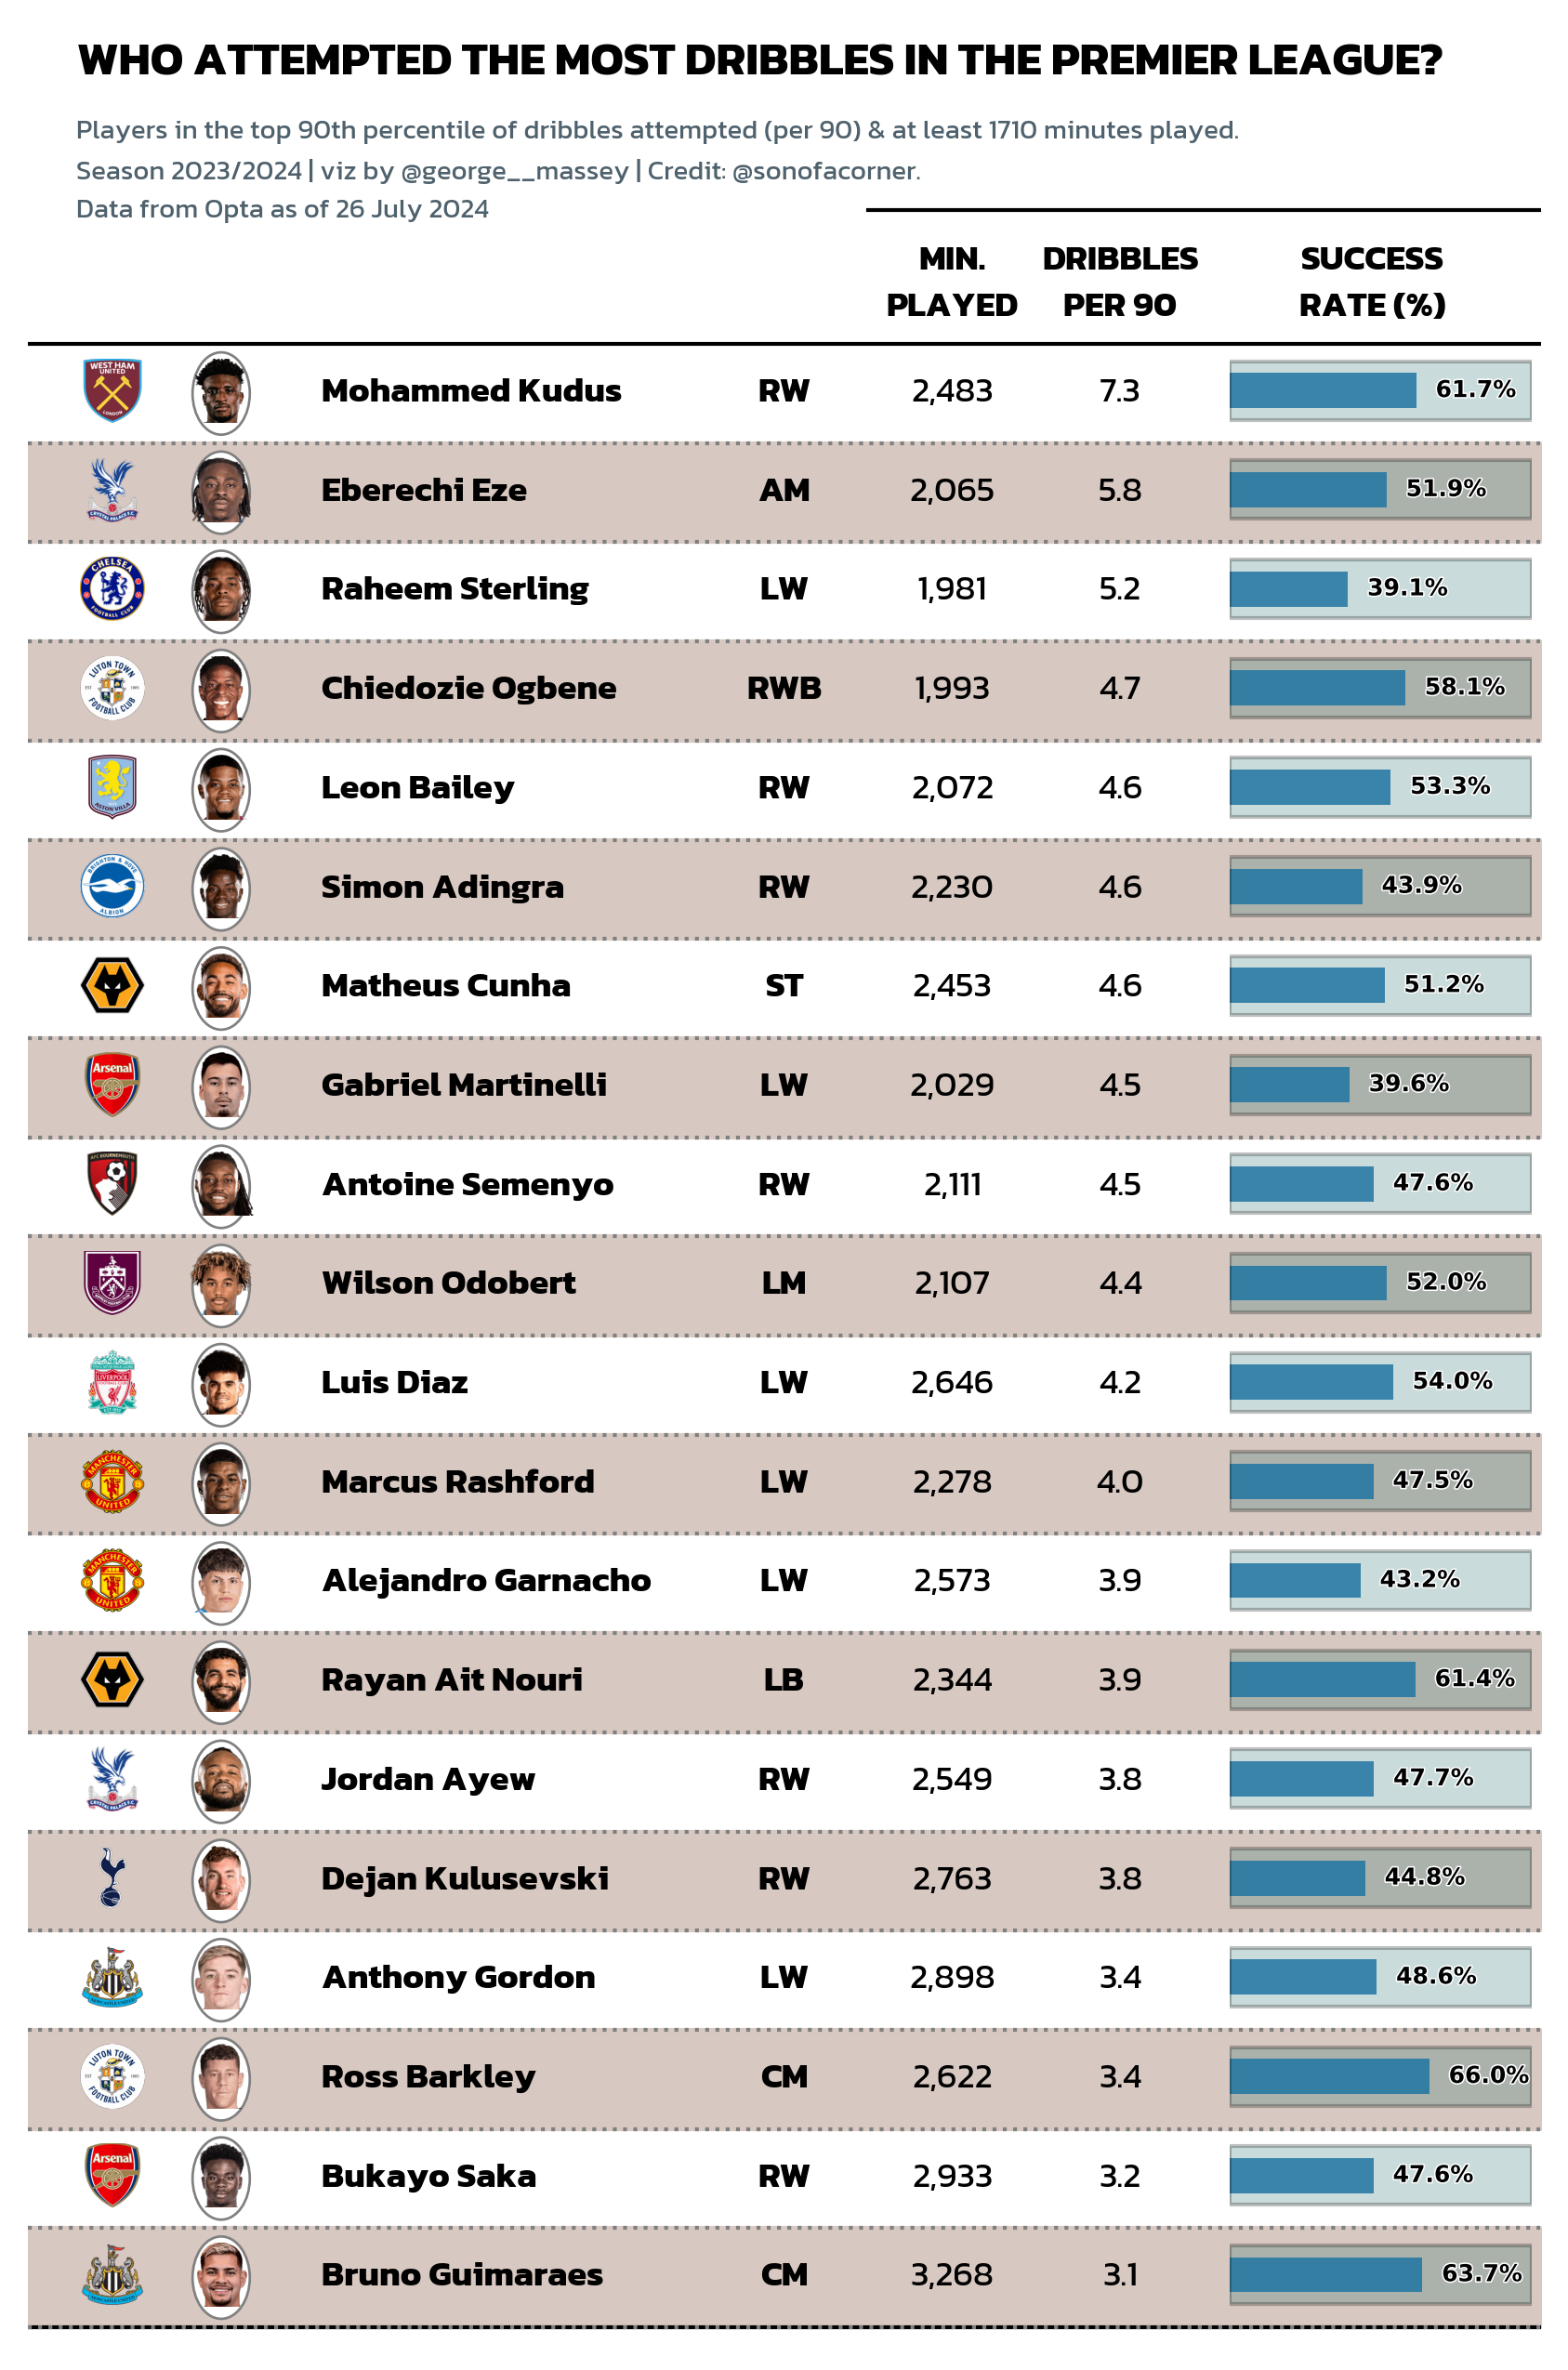

In [156]:
fig = plt.figure(figsize=(7,10), dpi=300)
ax = plt.subplot()

nrows = data_clean.shape[0]
ncols = data_clean.shape[1] - 1 # because I want to remove aprox. 3 columns from my DF

ax.set_xlim(0, ncols + 1)
ax.set_ylim(-.65, nrows + 1)

# calculate asymmetry of x and y axes: (I have no idea how this works)
x0, y0 = ax.transAxes.transform((0, 0)) # lower left in pixels
x1, y1 = ax.transAxes.transform((1, 1)) # upper right in pixes
dx = x1 - x0
dy = y1 - y0
maxd = max(dx, dy)
width = .24 * maxd / dx
height = .83 * maxd / dy

# Iterate
for y in range(0, nrows):
    print(y)
    # -- Club Logo
    bbox = Bbox.from_bounds(0, y - .295, 1, .65)
    logo_ax = fig.add_axes([0, 0, 0, 0], axes_locator=BboxLocator(bbox, ax.transData))
    draw_club_image_at_ax(data_clean['team_id'].iloc[y], logo_ax)
    # -- Player picture
    circle = Ellipse((1.15, y), width, height, ec='grey', fc=fig.get_facecolor(), transform=ax.transData, lw=.65)
    bbox = Bbox.from_bounds(.65, y - .295, 1, .65)
    logo_ax = fig.add_axes([0, 0, 0, 0], axes_locator=BboxLocator(bbox, ax.transData))
    draw_player_image_at_ax(data_clean['player_id'].iloc[y], logo_ax)
    ax.add_artist(circle)
    # -- Player name
    ax_text(
        x=1.75, y=y,
        s=data_clean['full_name'].iloc[y],
        weight='bold', size=9,
        ha='left', va='center', ax=ax, fontproperties = bold
    )
    # -- Player position
    ax_text(
        x=4.5, y=y,
        s=data_clean['position'].iloc[y],
        weight='bold', size=9,
        ha='center', va='center', ax=ax, fontproperties = bold
    )
    # -- Minutes played
    ax_text(
        x=5.5, y=y,
        s=f"{data_clean['minutes_played'].iloc[y]:,.0f}",
        size=9,
        ha='center', va='center', ax=ax, fontproperties = regular
    )
    # # -- Crosses
    ax_text(
        x=6.5, y=y,
        s=f"{data_clean['Dribbles attempted'].iloc[y]:,.1f}",
        size=9,
        ha='center', va='center', ax=ax, fontproperties = regular
    )
    # # -- Battery Chart
    bbox = Bbox.from_bounds(7.15, y - .295, 1.8, .65)
    battery_ax = fig.add_axes([0, 0, 0, 0], axes_locator=BboxLocator(bbox, ax.transData))
    battery_ax.set_xlim(0,1)
    battery_ax.barh(y=.5, width=data_clean['duel_success'].iloc[y], height=.3, alpha=.85)
    battery_ax.barh(y=.5, width=1, height=.5, alpha=.25, color='#287271', ec='black')
    text_ = battery_ax.annotate(
        xy=(data_clean['duel_success'].iloc[y], .5),
        xytext=(5,0),
        textcoords='offset points',
        text=f"{data_clean['duel_success'].iloc[y]:.1%}",
        ha='left', va='center',
        size=6, weight='bold'
    )
    text_.set_path_effects(
                [path_effects.Stroke(linewidth=.75, foreground="white"), 
                path_effects.Normal()]
            )
    battery_ax.set_axis_off()
    
#maxx = ax.get_xlim()[1]
#ax.set_xlim(0, maxx + 1)

# -- Draw border lines
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [nrows - .5, nrows - .5], lw=1, color='black', zorder=3)
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [-.5, -.5], lw=1, color='black', zorder=3)
for x in range(nrows):
    if x % 2 == 0:
        ax.fill_between(x=[ax.get_xlim()[0], ax.get_xlim()[1]], y1=x-.5, y2=x+.5, color='#d7c8c1', zorder=-1)
    ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [x - .5, x - .5], lw=1, color='grey', ls=':', zorder=3)

ax.set_axis_off()


# -- Column titles
ax_text(
    x=5.5, y=nrows + .1,
    s='MIN.\nPLAYED',
    size=9,
    ha='center', va='center', ax=ax,
    textalign='center', weight='bold', fontproperties = bold
)
ax_text(
    x=6.5, y=nrows + .1,
    s='DRIBBLES\nPER 90',
    size=9,
    ha='center', va='center', ax=ax,
    textalign='center', weight='bold', fontproperties = bold
)
ax_text(
    x=8, y=nrows + .1,
    s='SUCCESS\nRATE (%)',
    size=9,
    ha='center', va='center', ax=ax,
    textalign='center', weight='bold', fontproperties = bold
)

ax.plot([5, ax.get_xlim()[1]], [nrows + .85, nrows + .85], lw=1, color='black', zorder=3)

fig_text(
    x = 0.5, y = .92, 
    s = f"WHO ATTEMPTED THE MOST DRIBBLES IN THE {league.upper()}?",
    va = "bottom", ha = "center",
    fontsize = 12, color = "black",weight = "bold", fontproperties = bold
)
fig_text(
	x = 0.15, y = .87, 
    s = f"Players in the top {quant}th percentile of dribbles attempted (per 90) & at least {mins} minutes played.\nSeason 2023/2024 | viz by @george__massey | Credit: @sonofacorner.\nData from Opta as of {todays_date}",
	va = "bottom", ha = "left",
	fontsize = 7, color = "#4E616C", fontproperties = regular
)

plt.savefig(
	f"C:\\Users\\George\\Documents\\Football Analytics\\Visuals\\{league} dribbles_attempted {todays_date}.png",
	dpi = 600,
	facecolor = "#EFE9E6",
	bbox_inches="tight",
    edgecolor="none",
	transparent = False
)